In [1]:
# This code tests the capacity of MAC running generative AIs.
# The test is run on M4 Pro 14 Core CPU 20 Core GPU.

In [2]:
# A GAN generating images
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

# Check for MPS device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Hyperparameters
batch_size = 128
learning_rate = 0.0002
epochs = 10
latent_dim = 100

# Data loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(-1, 28 * 28))

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers and loss function
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(tqdm(train_loader)):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Train Discriminator
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        outputs = discriminator(imgs)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        outputs = discriminator(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        # if i % 100 == 0:
        #     print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

print("Training complete!")
torch.save(generator.state_dict(), "mnist_generator.pth")


100%|██████████| 469/469 [00:04<00:00, 93.80it/s]

Training complete!


In [6]:
generator = Generator().to(device)
generator.load_state_dict(torch.load("mnist_generator.pth", map_location=device))
generator.eval()

imgs_mps = []

for i in range(100):
    z = torch.randn(1, latent_dim).to(device)

    # Run inference on MPS
    with torch.no_grad():
        generated_image = generator(z).squeeze().cpu().numpy()
    
    imgs_mps.append(generated_image)

In [3]:
import torch
import coremltools as ct

# Load trained PyTorch model
latent_dim = 100  # Define latent dimension size
generator = Generator()
generator.load_state_dict(torch.load("mnist_generator.pth", map_location=torch.device("cpu")))
generator.eval()

# Example input tensor for tracing
example_input = torch.randn(1, latent_dim)

# Trace the model
traced_model = torch.jit.trace(generator, example_input)

# Convert to Core ML
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.TensorType(shape=example_input.shape)],
    convert_to="mlprogram",  # Convert to mlprogram to enable ANE execution
    source="pytorch",
)

# Save the Core ML model
mlmodel.save("mnist_generator.mlpackage")
print("Model successfully converted to Core ML!")


Torch version 2.6.0.dev20241112 has not been tested with coremltools. You may run into unexpected errors. Torch 2.5.0 is the most recent version that has been tested.
Running MIL default pipeline:   0%|          | 0/89 [00:00<?, ? passes/s]/opt/anaconda3/envs/AI/lib/python3.12/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '28', of the source model, has been renamed to 'var_28' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 9851.57 passes/s]

Model successfully converted to Core ML!


  0%|          | 0/100 [00:00<?, ?it/s]

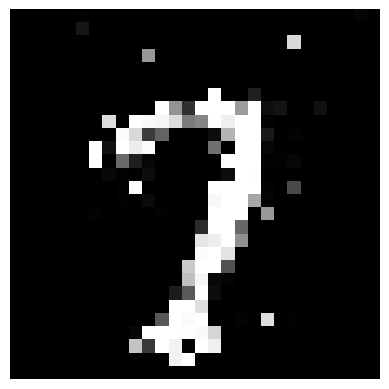

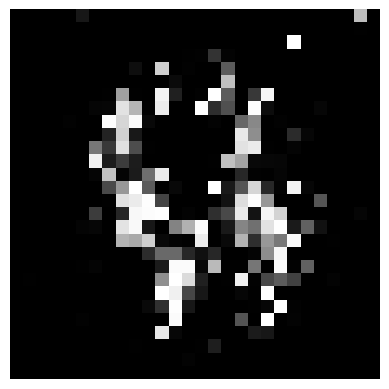

  2%|▏         | 2/100 [00:00<00:05, 18.36it/s]

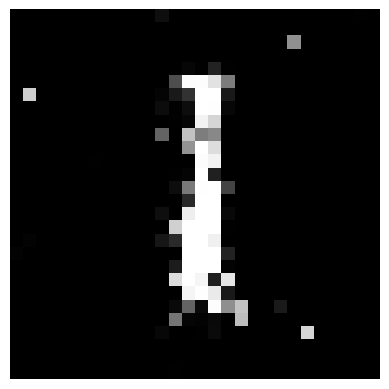

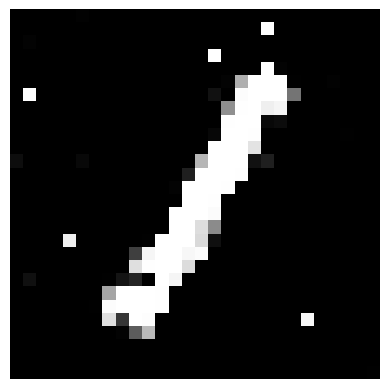

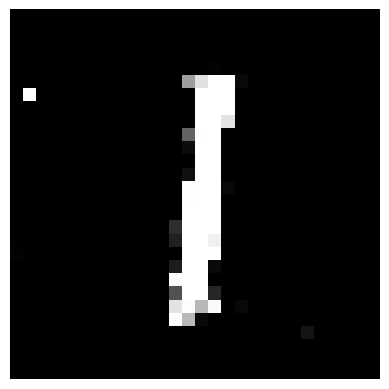

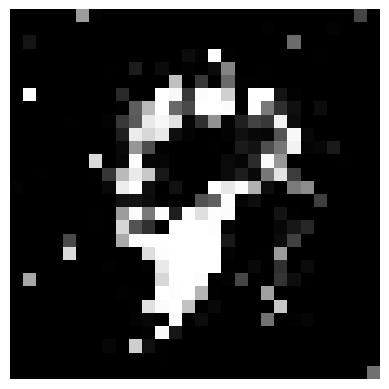

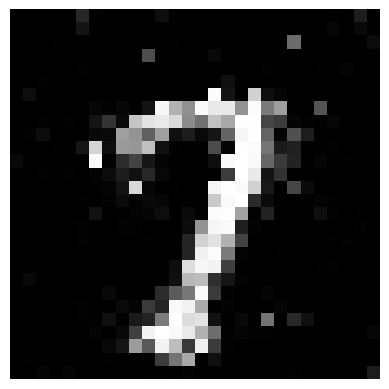

  7%|▋         | 7/100 [00:00<00:03, 27.26it/s]

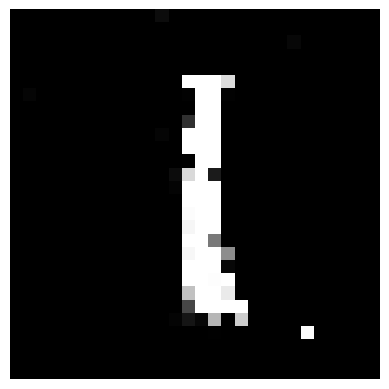

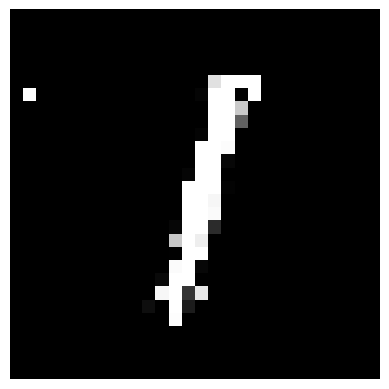

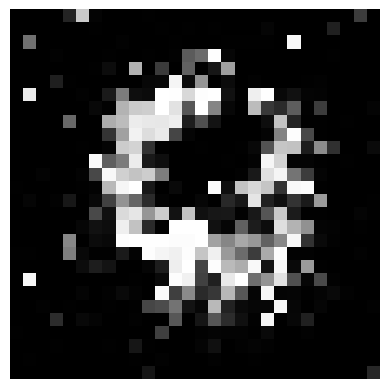

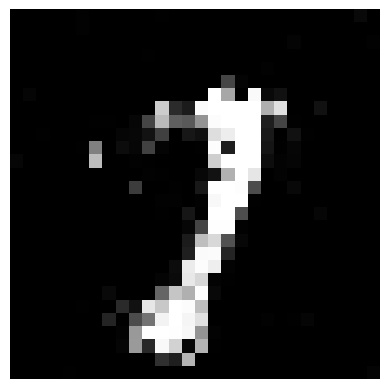

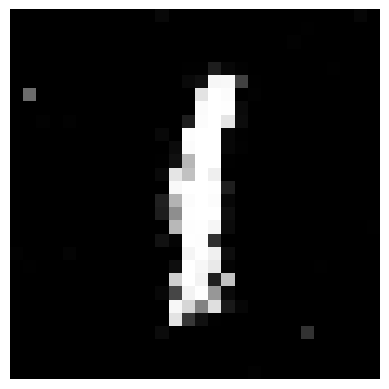

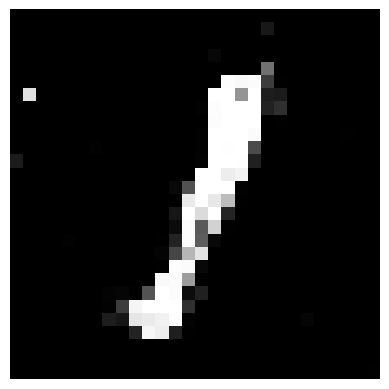

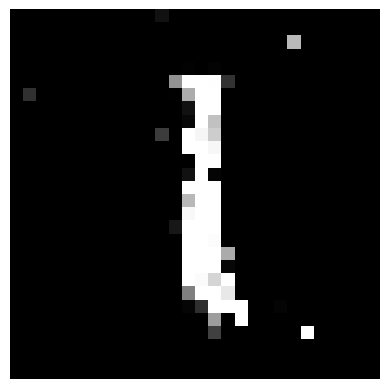

 14%|█▍        | 14/100 [00:00<00:02, 41.80it/s]

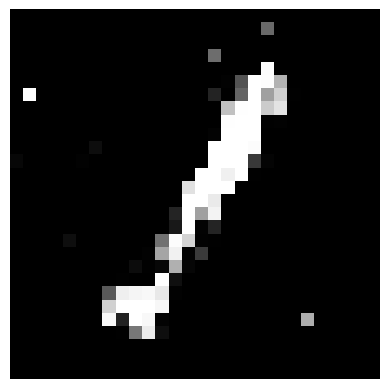

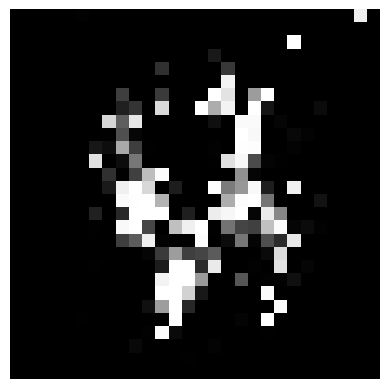

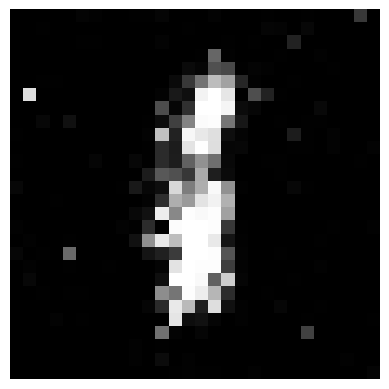

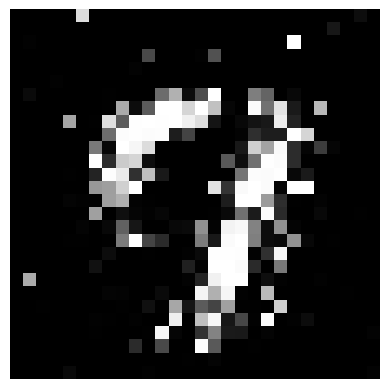

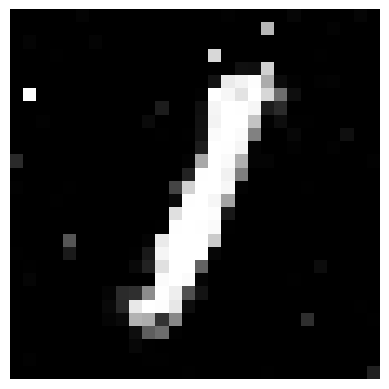

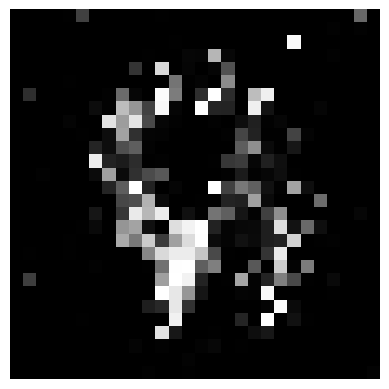

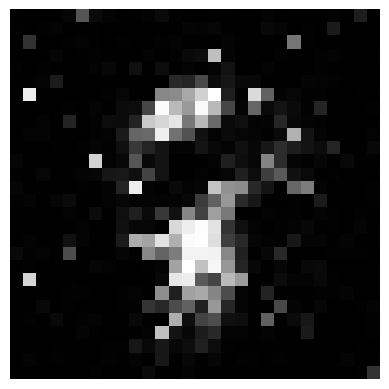

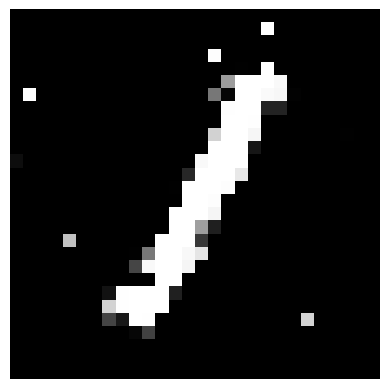

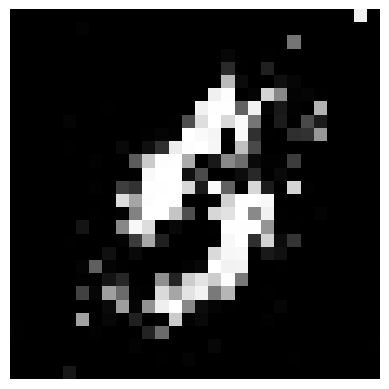

 23%|██▎       | 23/100 [00:00<00:01, 57.00it/s]

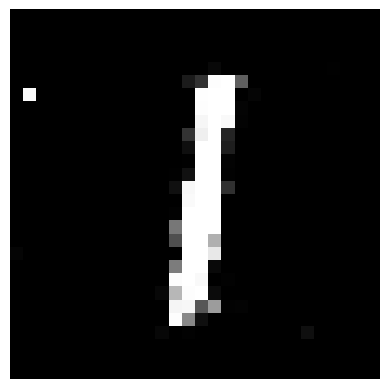

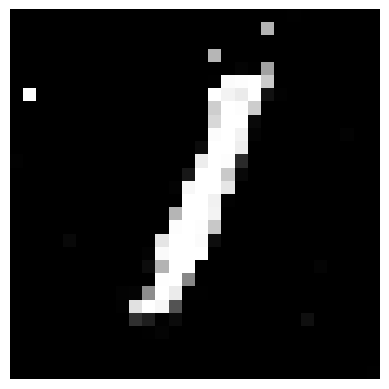

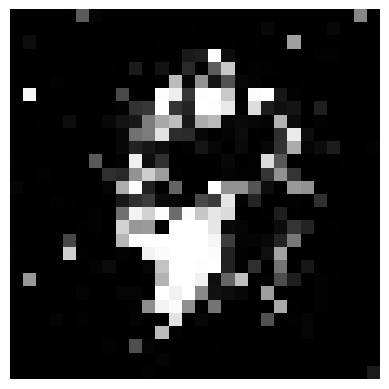

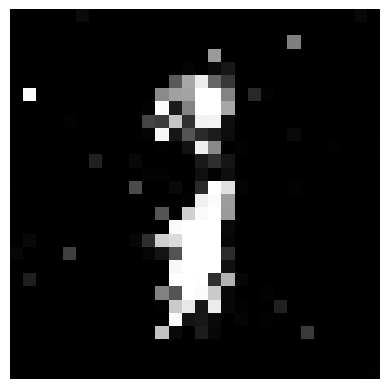

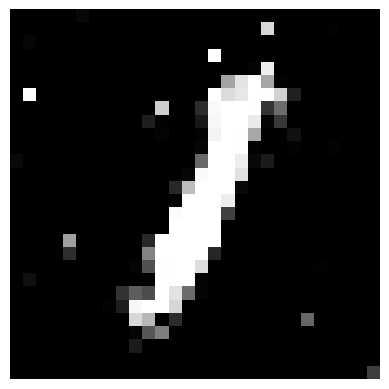

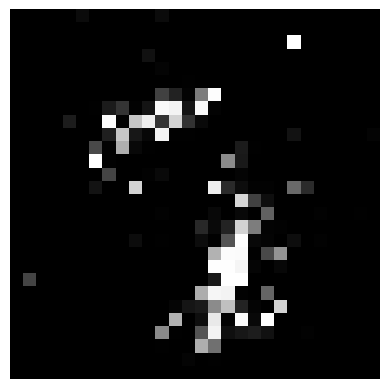

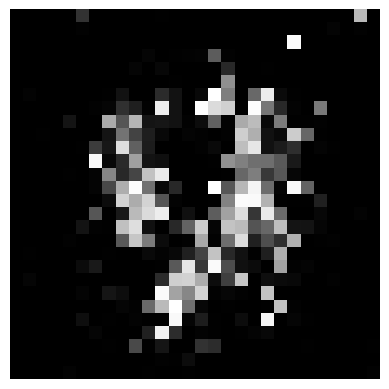

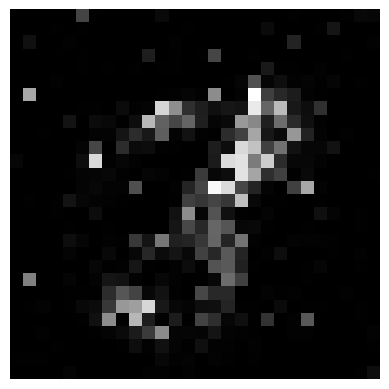

 31%|███       | 31/100 [00:00<00:01, 63.22it/s]

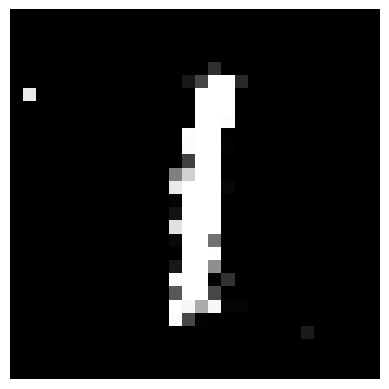

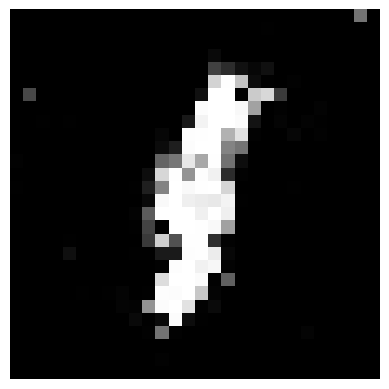

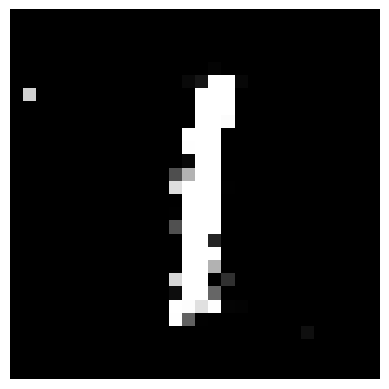

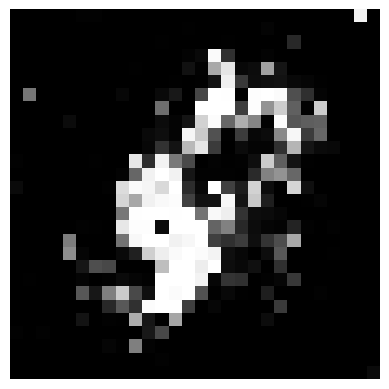

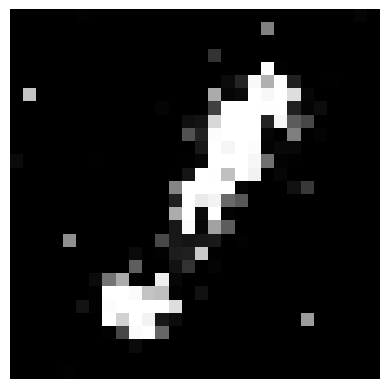

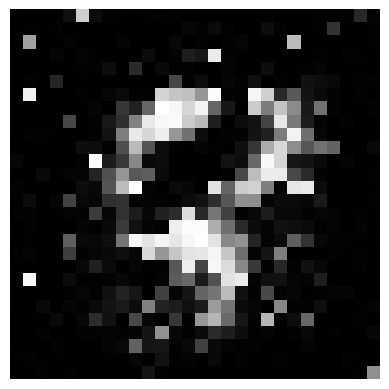

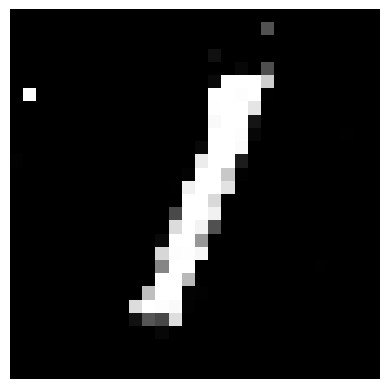

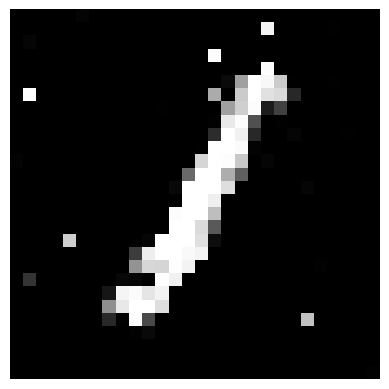

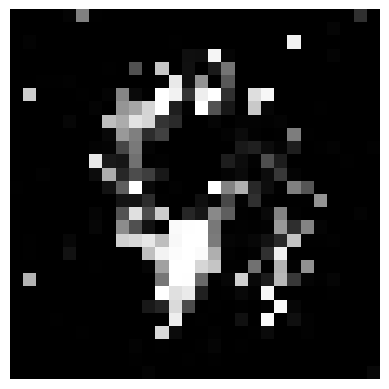

 40%|████      | 40/100 [00:00<00:00, 69.09it/s]

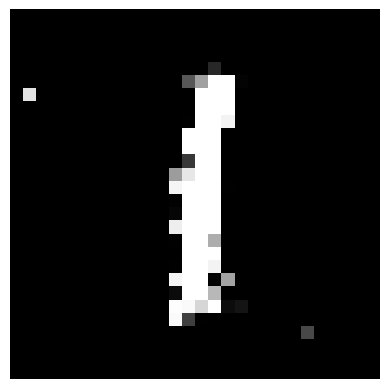

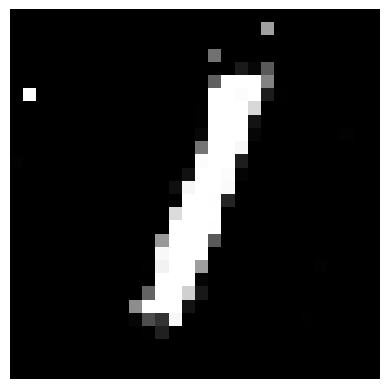

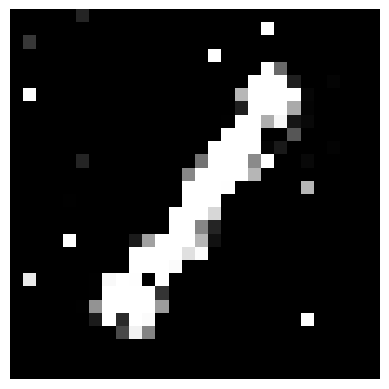

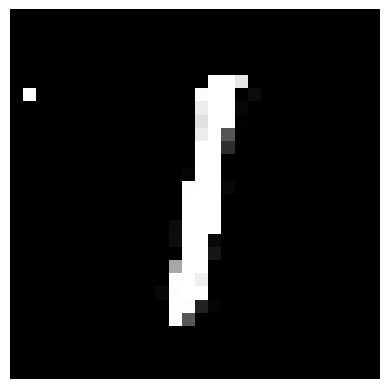

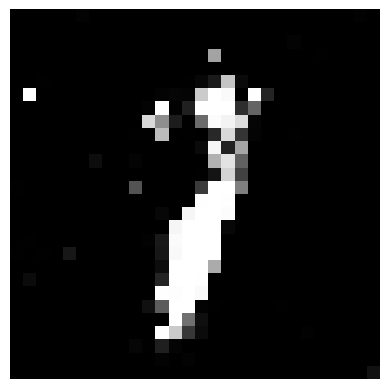

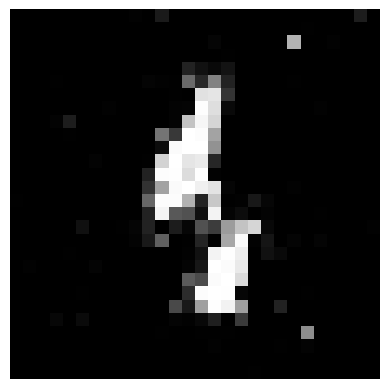

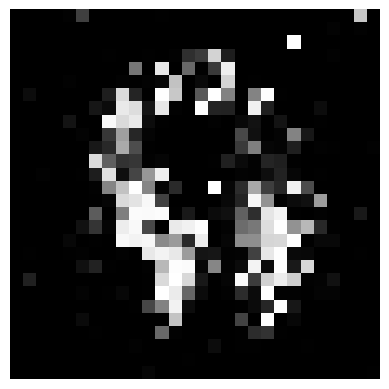

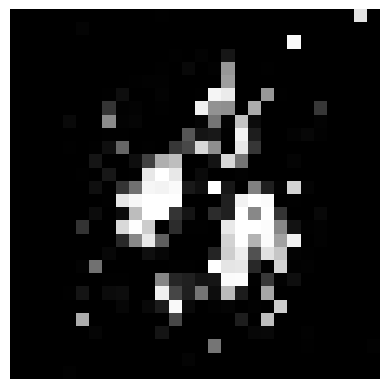

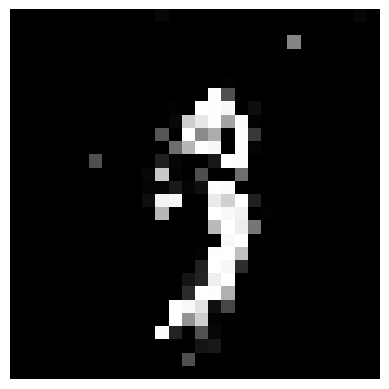

 49%|████▉     | 49/100 [00:00<00:00, 71.18it/s]

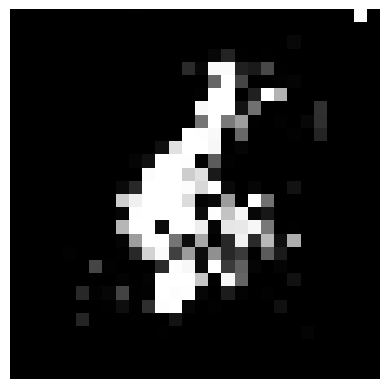

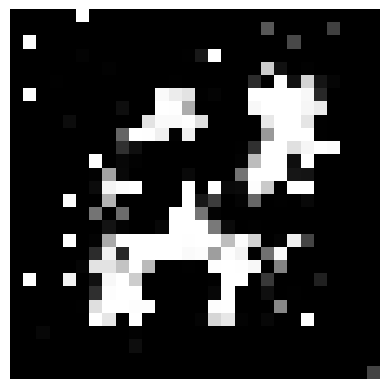

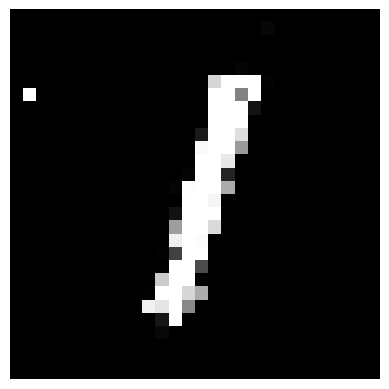

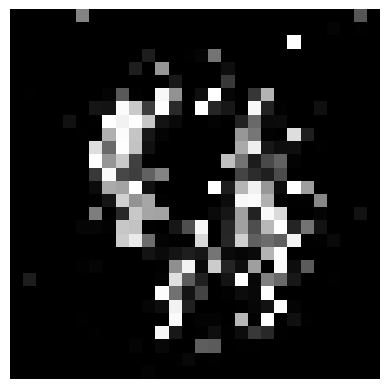

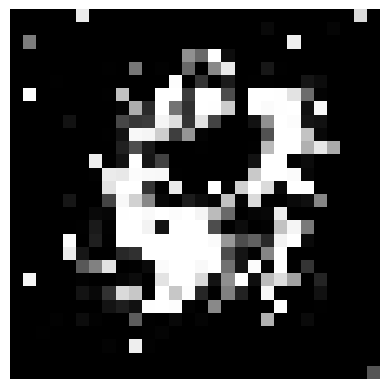

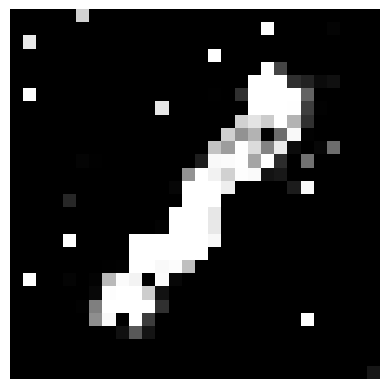

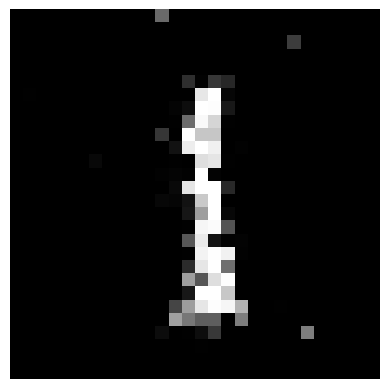

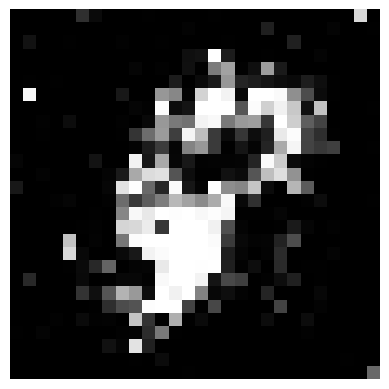

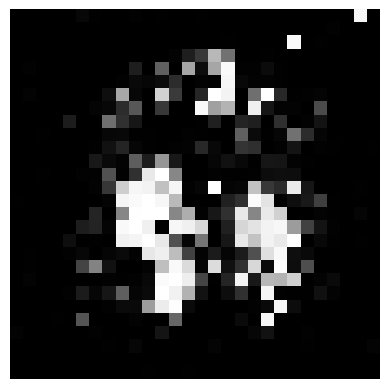

 58%|█████▊    | 58/100 [00:00<00:00, 74.45it/s]

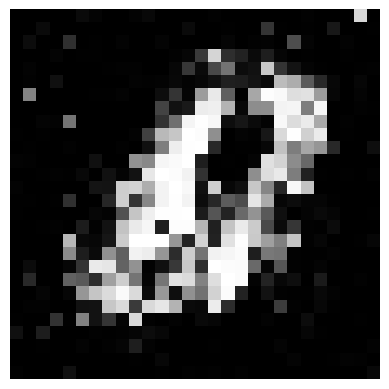

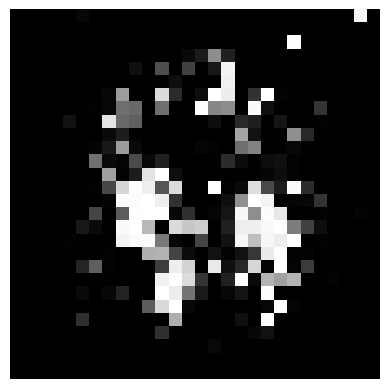

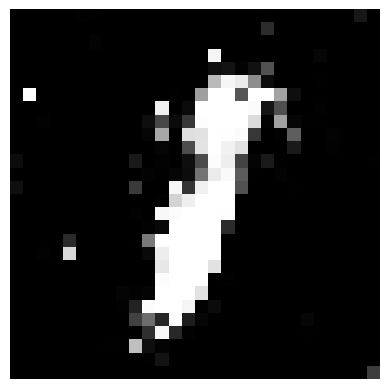

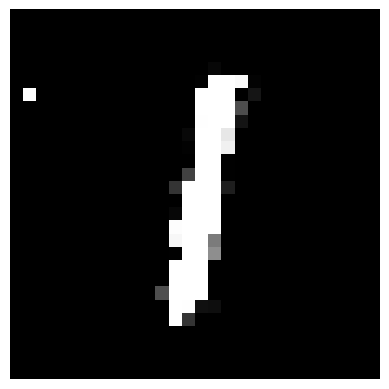

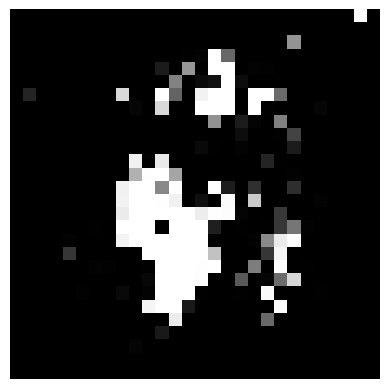

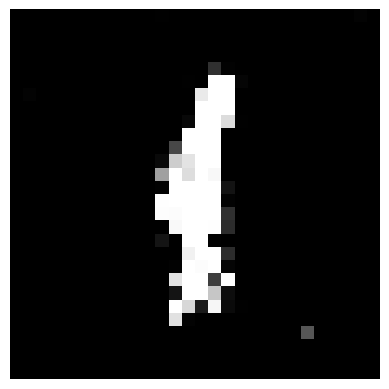

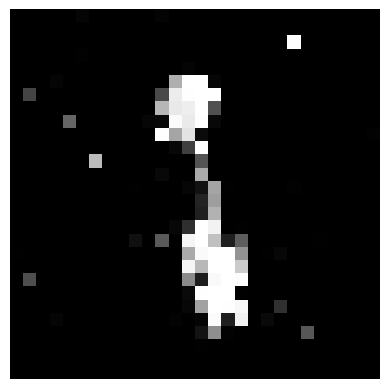

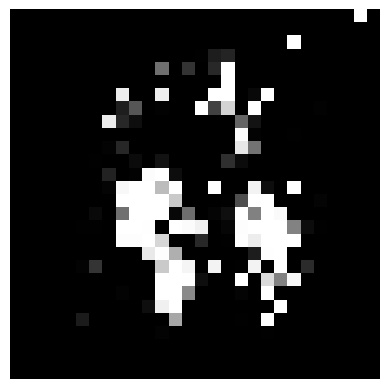

 66%|██████▌   | 66/100 [00:01<00:00, 73.43it/s]

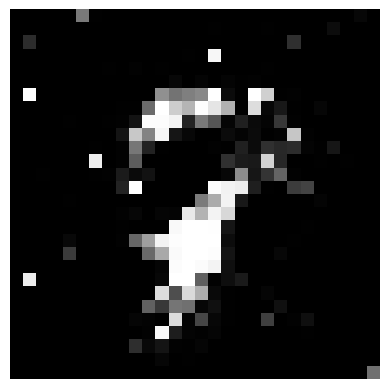

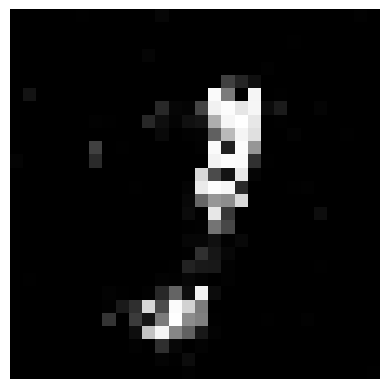

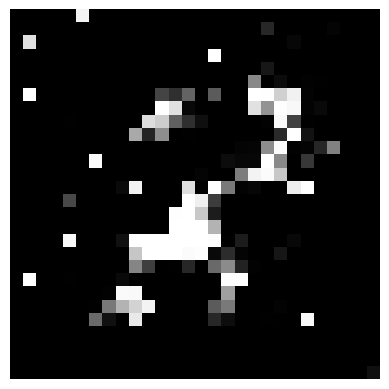

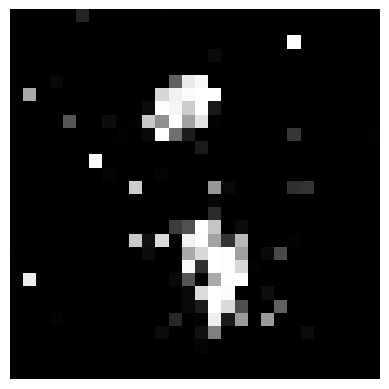

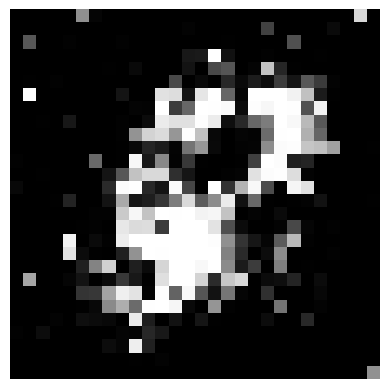

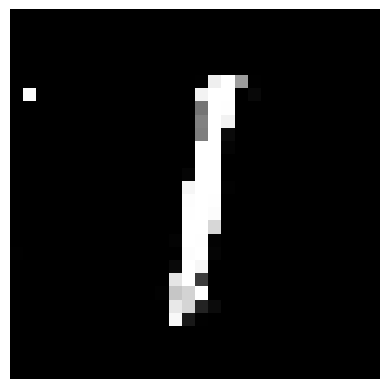

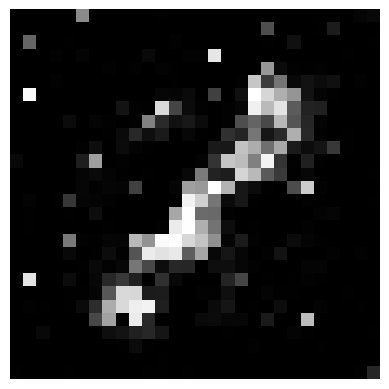

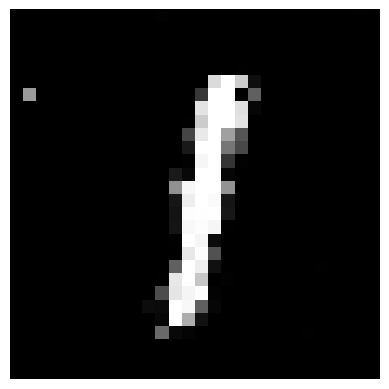

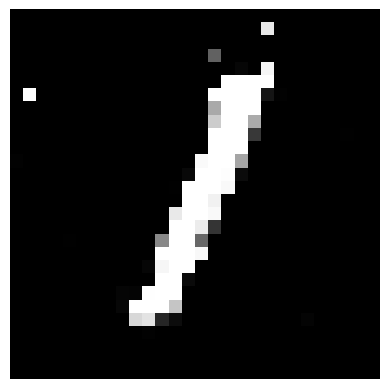

 75%|███████▌  | 75/100 [00:01<00:00, 74.60it/s]

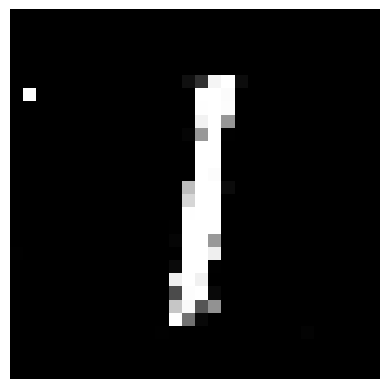

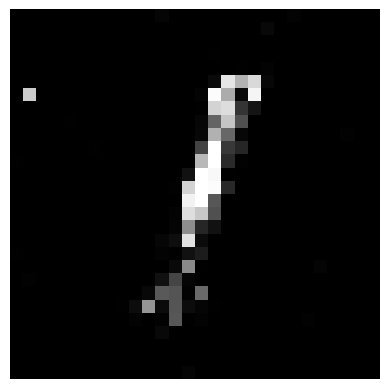

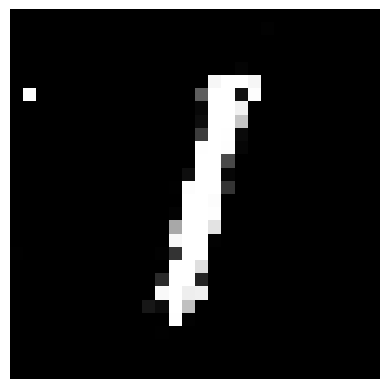

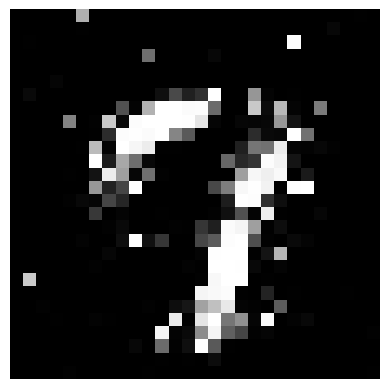

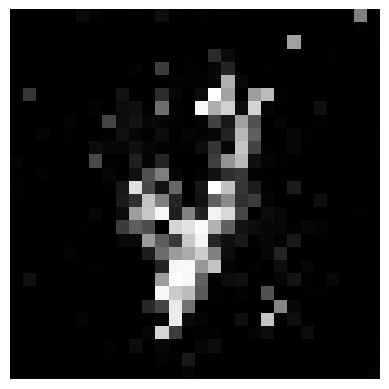

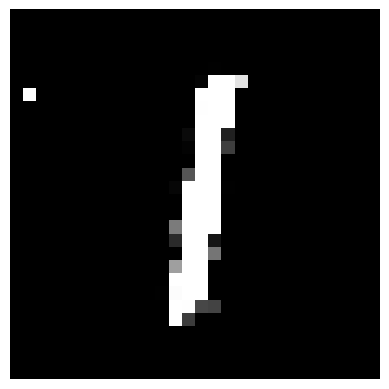

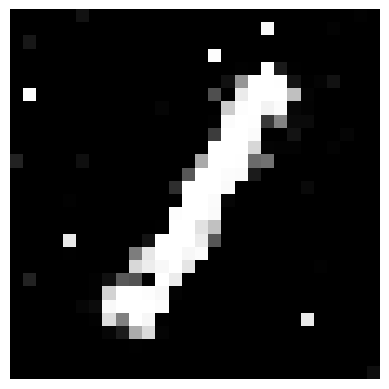

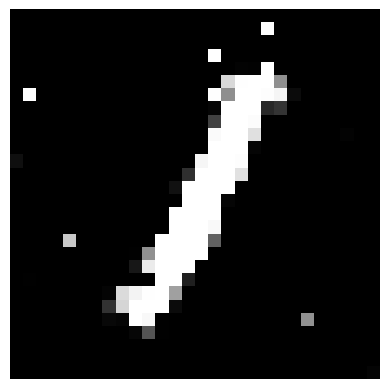

 83%|████████▎ | 83/100 [00:01<00:00, 75.77it/s]

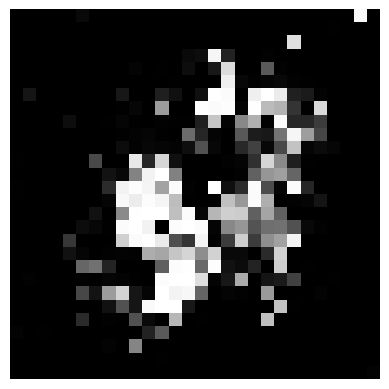

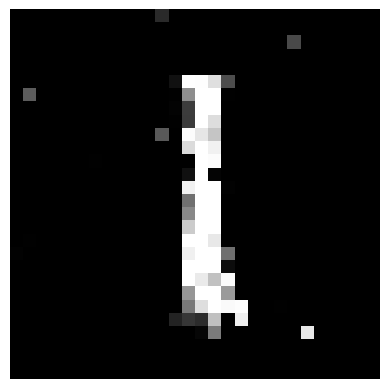

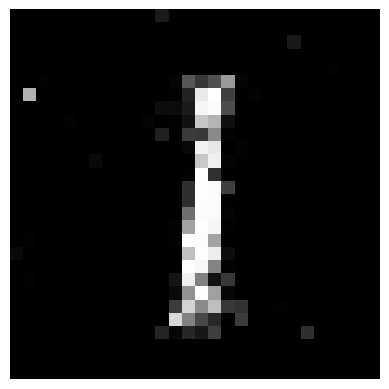

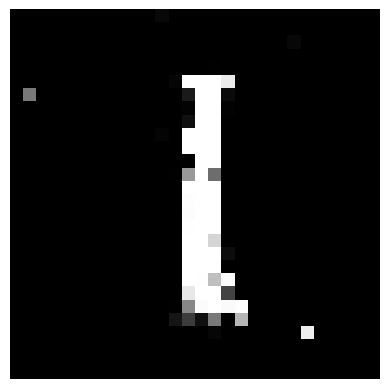

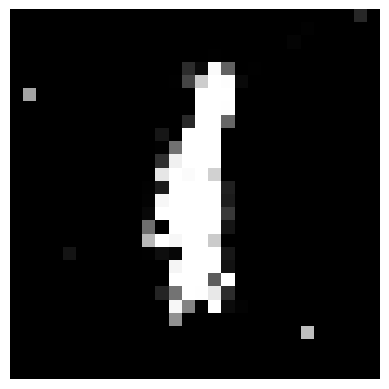

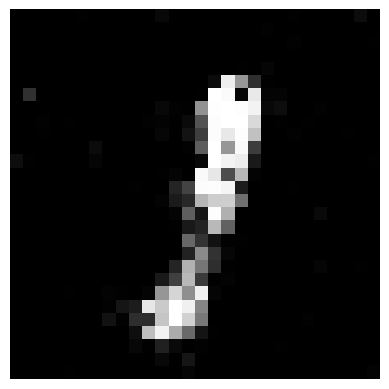

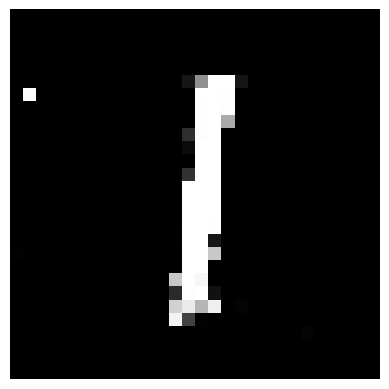

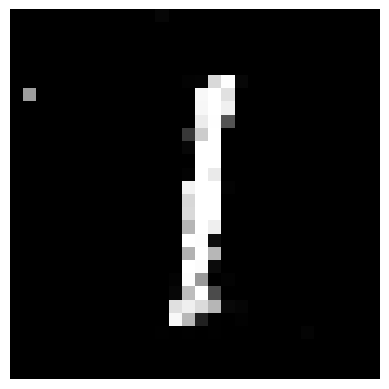

 91%|█████████ | 91/100 [00:01<00:00, 76.10it/s]

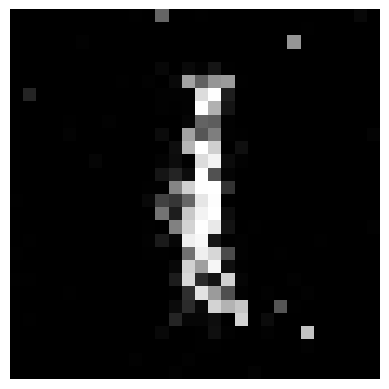

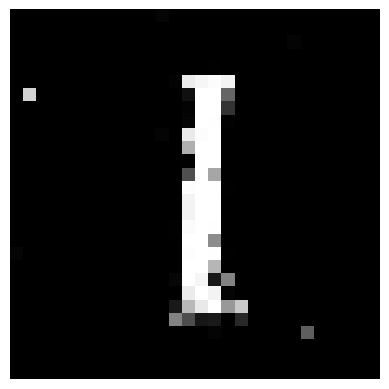

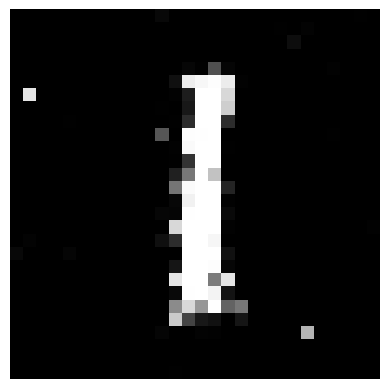

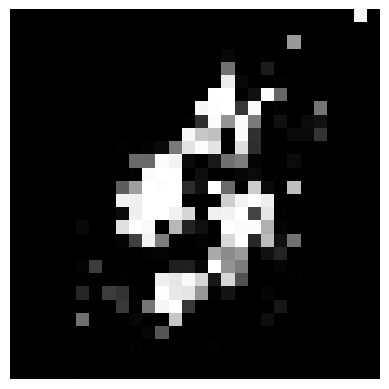

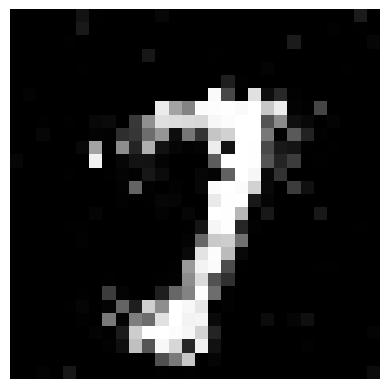

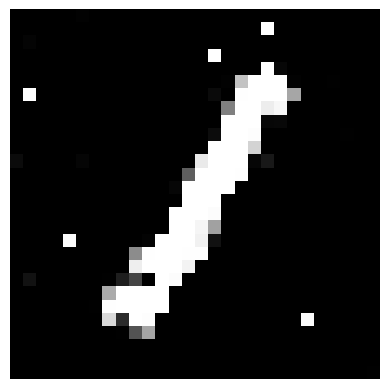

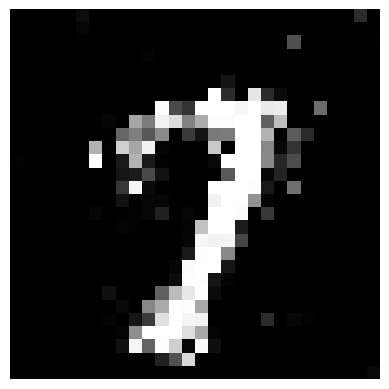

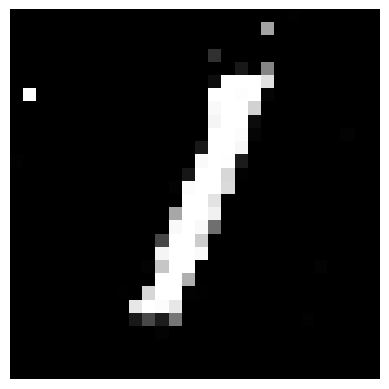

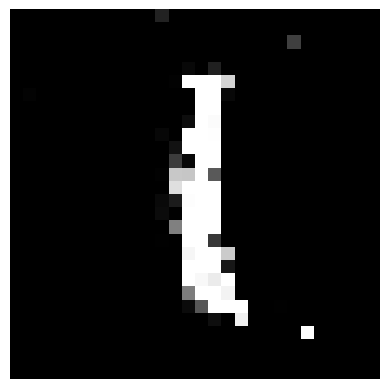

100%|██████████| 100/100 [00:01<00:00, 67.95it/s]


In [ ]:
#inference

import coremltools
import numpy as np
# from PIL import Image
import matplotlib.pyplot as plt

# Load Core ML model
mlmodel = coremltools.models.MLModel("mnist_generator.mlpackage")
imgs = []

for i in trange(100):
    # Generate latent vector
    latent_vector = np.random.randn(1, latent_dim).astype(np.float32)

    # Run inference on ANE
    output = mlmodel.predict({"z": latent_vector})
    # print(output)
    generated_image = output["var_28"].reshape(28, 28)
    imgs.append(generated_image)

    # Convert to image
    # image = Image.fromarray((generated_image * 255).astype(np.uint8))
    # plt.imshow(generated_image, cmap="gray")
    # plt.axis("off")
    # plt.show()
    # image.show()
